In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 1) Load the full training‐level feature set
df = pd.read_csv("../top_10_features_train.csv")

# 2) Split off 30% for validation, stratified on HIGH_SEVERITY
train_df, val_df = train_test_split(
    df, test_size=0.3, stratify=df["HIGH_SEVERITY"], random_state=42
)

# 3) Prep function to extract X/y and clean
def prep(df):
    X = (
        df.select_dtypes(include=[np.number])
        .drop(columns=["ACCIDENT_NO", "HIGH_SEVERITY"], errors="ignore")
        .replace([np.inf, -np.inf], np.nan)
        .fillna(0)
    ) 
    y = df["HIGH_SEVERITY"]
    return X, y


# 4) Create train/val splits
X_train, y_train = prep(train_df)
X_val, y_val = prep(val_df)

Train: (107873, 10) {0: 67047, 1: 40826}
Val:   (46232, 10) {0: 28735, 1: 17497}


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'max_depth': 5, 'min_samples_leaf': 10}
Best cross-val F1: 0.5332542345711861

Decision Tree (tuned) Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.58      0.64     28735
           1       0.47      0.60      0.53     17497

    accuracy                           0.59     46232
   macro avg       0.59      0.59      0.58     46232
weighted avg       0.62      0.59      0.60     46232



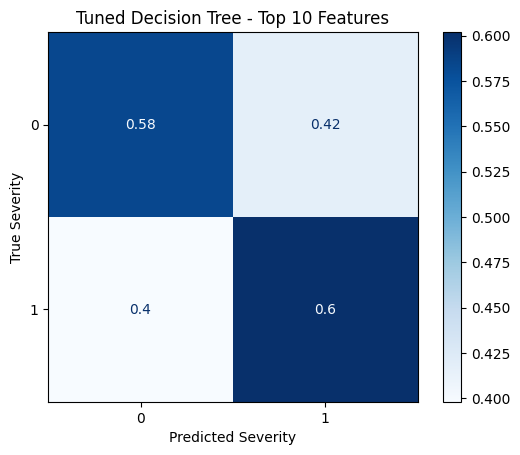

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1) Define the parameter grid
param_grid = {"max_depth": [3, 5, 7], "min_samples_leaf": [1, 5, 10]}

# 2) Set up a stratified k-fold splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3) Wrap your tree in GridSearchCV
grid = GridSearchCV(
    estimator=DecisionTreeClassifier(class_weight="balanced", random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
)

# 4) Fit on the training data
grid.fit(X_train, y_train)

# 5) Inspect best params & best score
print("Best parameters:", grid.best_params_)
print("Best cross-val F1:", grid.best_score_)

# 6) Evaluate the best estimator on the hold-out set
best_tree = grid.best_estimator_
y_pred = best_tree.predict(X_val)

print("\nDecision Tree (tuned) Classification Report:\n")
print(classification_report(y_val, y_pred, zero_division=0))

disp = ConfusionMatrixDisplay.from_predictions(
    y_val,
    y_pred,
    display_labels=best_tree.classes_,
    normalize="true",
    cmap=plt.cm.Blues,
)
plt.title("Tuned Decision Tree - Top 10 Features")
plt.xlabel("Predicted Severity")
plt.ylabel("True Severity")
#plt.savefig("../figures/confusion_matrices/top_10_features/decision_tree.png")
plt.show()

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 200}
Best cross-val F1: 0.5322008244203333

Random Forest (tuned) Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.61      0.66     28735
           1       0.48      0.59      0.53     17497

    accuracy                           0.60     46232
   macro avg       0.59      0.60      0.59     46232
weighted avg       0.62      0.60      0.61     46232



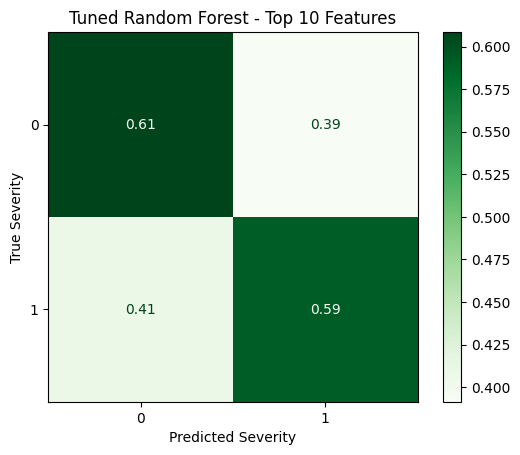

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# 1) Define a small parameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10],
    "min_samples_leaf": [1, 5, 10],
}

# 2) Stratified 5-fold splitter
cv = StratifiedKFold(n_splits=5, shuffle=True)

# 3) Wrap in GridSearchCV
grid = GridSearchCV(
    estimator=RandomForestClassifier(
        class_weight="balanced", n_jobs=-1
    ),
    param_grid=param_grid,
    cv=cv,
    scoring="f1", 
    n_jobs=-1,
    verbose=1,
)

# 4) Fit on the train set
grid.fit(X_train, y_train)

# 5) Best params & CV score
print("Best parameters:", grid.best_params_)
print("Best cross-val F1:", grid.best_score_)

# 6) Evaluate on the hold-out set
best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_val)

print("\nRandom Forest (tuned) Classification Report:\n")
print(classification_report(y_val, y_pred, zero_division=0))

disp = ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred, display_labels=best_rf.classes_, normalize="true", cmap=plt.cm.Greens
)
plt.title("Tuned Random Forest - Top 10 Features")
plt.xlabel("Predicted Severity")
plt.ylabel("True Severity")
#plt.savefig("../figures/confusion_matrices/top_10_features/random_forest.png")
plt.show()

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'knn__algorithm': 'ball_tree', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
Best cross-val F1: 0.43513056079380047

KNN (tuned) Classification Report:

              precision    recall  f1-score   support

           0       0.65      0.65      0.65     28735
           1       0.43      0.43      0.43     17497

    accuracy                           0.57     46232
   macro avg       0.54      0.54      0.54     46232
weighted avg       0.57      0.57      0.57     46232



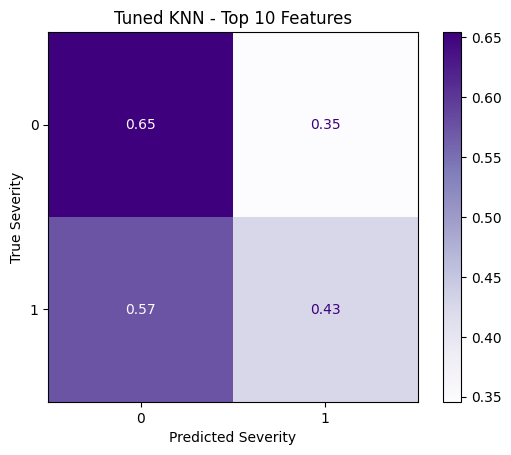

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# 1) Base pipeline
pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_jobs=-1))]
)

# 2) Parameter grid - knn__ prefix when using a Pipeline
param_grid = {
    "knn__n_neighbors": [1, 3, 5, 7],
    "knn__weights": ["uniform", "distance"],
}

# 3) Stratified 5‐fold CV splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4) GridSearchCV
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
)

# 5) Fit on the training set
grid.fit(X_train, y_train)

# 6) Print best params & CV score
print("Best parameters:", grid.best_params_)
print("Best cross-val F1:", grid.best_score_)

# 7) Evaluate tuned model on the hold‐out set
best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_val)

print("\nKNN (tuned) Classification Report:\n")
print(classification_report(y_val, y_pred, zero_division=0))

disp = ConfusionMatrixDisplay.from_predictions(
    y_val,
    y_pred,
    display_labels=best_knn.named_steps["knn"].classes_,
    normalize="true",
    cmap=plt.cm.Purples,
)
plt.title("Tuned KNN - Top 10 Features")
plt.xlabel("Predicted Severity")
plt.ylabel("True Severity")
#plt.savefig("../figures/confusion_matrices/top_10_features/knn.png")
plt.show()